In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


# inspect the features

In [6]:
features = np.load('./features.npy')

In [7]:
features.shape

(12, 900, 20)

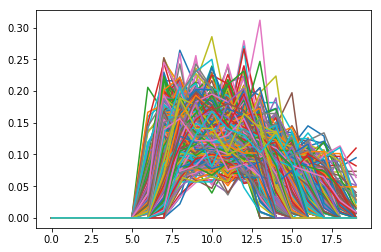

In [8]:
for feature in features[0]:
    plt.plot(feature)

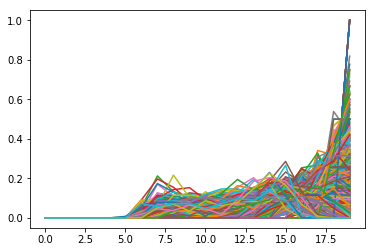

In [9]:
for feature in features[1]:
    plt.plot(feature)

In [10]:
y = np.tile(np.r_[np.ones(900), np.zeros(900)], 6).reshape(12, 900)

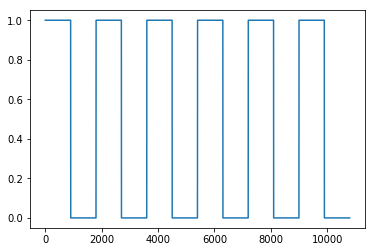

In [11]:
plt.plot(y.reshape(-1))

# check training vs epochs

In [12]:
Xc = features

In [13]:
train_id = [0,1]
test_id = [2,3,4,5,6,7,8,9,10,11]

x_train = np.r_[tuple([Xc[i] for i in train_id])]
x_test  = np.r_[tuple([Xc[i] for i in test_id])]

y_train = y[train_id].reshape(-1) #np.r_[tuple([y[i] for i in train_id])]
y_test  = y[test_id].reshape(-1) #np.r_[tuple([y[i] for i in test_id])]

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(64, input_dim=20, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train, validation_split=0.3, epochs=1000, batch_size=1000, verbose=0)

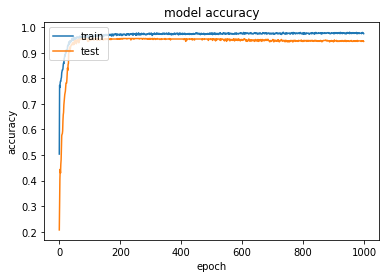

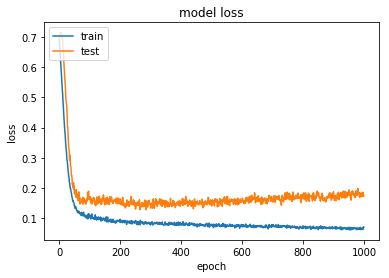

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# K-fold validation

In [17]:
def split_data(train, test):
    
    train_id = train
    test_id = test

    x_train = np.r_[tuple([Xc[i] for i in train_id])]
    x_test  = np.r_[tuple([Xc[i] for i in test_id])]

    y_train = y[train_id].reshape(-1)
    y_test  = y[test_id].reshape(-1)
    
    return x_train, x_test, y_train, y_test

In [18]:
def get_model():
    model = Sequential()
    model.add(Dense(64, input_dim=20, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [19]:
n_dataset = len(Xc)
n_splits = 3

kf = KFold(n_splits = n_splits)
for train, test in kf.split(range(n_dataset)):
    print("%s %s" % (train, test))

[ 4  5  6  7  8  9 10 11] [0 1 2 3]
[ 0  1  2  3  8  9 10 11] [4 5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10 11]


[ 4  5  6  7  8  9 10 11] [0 1 2 3]
[ 0  1  2  3  8  9 10 11] [4 5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10 11]


(-0.1, 1.1)

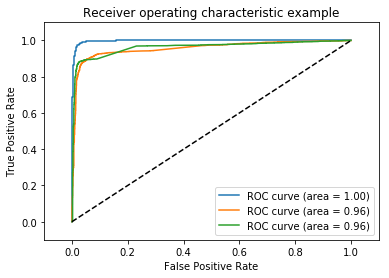

In [20]:
from sklearn.model_selection import KFold

    
fig, ax = plt.subplots()


n_dataset = len(Xc)
n_splits = 3

fprs = []
tprs = []
thrs = []

kf = KFold(n_splits = n_splits)
for train, test in kf.split(range(n_dataset)):
    print("%s %s" % (train, test))
    
    x_train, x_test, y_train, y_test = split_data(train, test)
    
    model = get_model()
    history = model.fit(x_train, y_train, validation_split=0.3, epochs=200, batch_size=1000, verbose=0)
    y_pred = model.predict(x_test)
    
    fpr, tpr, thr = metrics.roc_curve(y_test, y_pred)
    
    fprs.append(fpr)
    tprs.append(tpr)
    thrs.append(thr)

    roc_auc = metrics.auc(fpr, tpr)

    metrics_classification_report = metrics.classification_report(y_test, np.round(y_pred))
#     print metrics.classification_report(y_test, np.round(y_pred))

    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")    
ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Luck')

ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])

In [21]:
import seaborn as sns

(-0.1, 1.1)

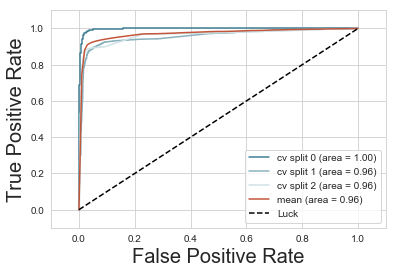

In [22]:
from scipy import interp

# sns.set_style("ticks")
sns.set_style("whitegrid")
fig, ax = plt.subplots()

colors = sns.cubehelix_palette(4)
colors = sns.diverging_palette(220, 20, n=6)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
 

for i in range(n_splits):
    fpr, tpr = fprs[i], tprs[i]
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label='cv split %d (area = %0.2f)' % (i, roc_auc), color=colors[i])

    mean_tpr += interp(mean_fpr, fpr, tpr)

mean_tpr[0] = 0.0
mean_tpr /= n_splits
mean_tpr[-1] = 1.0

ax.plot(mean_fpr, mean_tpr, label='mean (area = %0.2f)' % roc_auc, color=colors[-1])
ax.plot([0, 1], [0, 1], color='k', label='Luck', linestyle='--')

    
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
# ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")    
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
